In [819]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import normalize
from sqlalchemy import create_engine


import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_prices = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

# Data Cleaning and Exploration

In [820]:
houses_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


The dataframe has 81 columns. It is very hard to have information about all these columns from the above table

## Missing Values

In [821]:
total_missing = houses_prices.isnull().sum().sort_values(ascending=False)
percent_missing = (houses_prices.isnull().sum()/houses_prices.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(19)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


TheseSare the missing values per column. Some of them has few missing values while the others has a very high percentage of missing values.

Lets check them one by one:

Most of the missing values are representing a category (N/A) since these features are nominal categorical variables. these values are not missed by mistake but it should represent a category (N/A). For example, feature "alley" is categorical variable representign the type of alley acces to the house. it has 3 different values (paved, gravle, no alley acces), the last one is the missing values. For these missign values, we will fill all with the string "N/A"

Other features are missing because it should not have a value due to non availability. This condition matches 2 features ("garageyrblt", and "masvnrarea"). These values are missing because for the first one, these house has no garage to have a value for the year built, and no masonry veneer to have an area for it for the second one. For "masvnrarea" feature a value of "zero" will be filled instead of a missing value, while for "garageyrblt" we an not do the same, and this couln will be dropped from the dataset because it has problems and it less likely will affect the sale price of the house.

The last 2 features ("lotfrontage" and "electrical"). these features missing values where missed by mistake. it make no sense top have a house with no street connected to the property, and no house can be without an electrical system. for the "electrical" feature, the row with missing value will be dropped since it represents less than 0.1% of the data. For the "lotfrontage" it will be filled with the mean lot frontage of the houses based on its neighbourhood.

**First**, The below features missing values are replaced with a string (N/A) representing an additional category. All these featyres are Nominal Categorical Variables

In [822]:
missing_values1 = ['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'garagecond', 'garagetype', 'garagefinish',
                  'garagequal', 'bsmtexposure', 'bsmtfintype2', 'bsmtfintype1', 'bsmtcond', 'bsmtqual', 'masvnrtype']

for i in range(0, len(missing_values1)):
    houses_prices[missing_values1[i]].fillna('N/A', inplace = True)

**Second**, The missing values of feature 'masvnrarea' is replaced by "zero", and the feature 'garageyrblt' is dropped from the dataframe.

In [823]:
houses_prices['masvnrarea'].fillna(0, inplace = True)
houses_prices = houses_prices.drop(['garageyrblt'], axis=1)

**Finally**, The only row with a missing 'electrical' value is dropped from the dataframe, and the missing values for 'lotfrontage' is replaced with the mean lotfrontage of the house neighborhood.

In [824]:
houses_prices = houses_prices.dropna(axis = 0, subset = ['electrical'])

neighborhoods = houses_prices['neighborhood'].unique()

for neighborhood in neighborhoods:
    houses_prices.loc[houses_prices['neighborhood'] == neighborhood, 'lotfrontage'] = \
                                    houses_prices.loc[houses_prices["neighborhood"] == neighborhood, 'lotfrontage'].mean()

## Outliers

In [732]:
houses_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
id               1459 non-null int64
mssubclass       1459 non-null int64
mszoning         1459 non-null object
lotfrontage      1459 non-null float64
lotarea          1459 non-null int64
street           1459 non-null object
alley            1459 non-null object
lotshape         1459 non-null object
landcontour      1459 non-null object
utilities        1459 non-null object
lotconfig        1459 non-null object
landslope        1459 non-null object
neighborhood     1459 non-null object
condition1       1459 non-null object
condition2       1459 non-null object
bldgtype         1459 non-null object
housestyle       1459 non-null object
overallqual      1459 non-null int64
overallcond      1459 non-null int64
yearbuilt        1459 non-null int64
yearremodadd     1459 non-null int64
roofstyle        1459 non-null object
roofmatl         1459 non-null object
exterior1st      1459 non

In [825]:
houses_prices['yr_mo_sold'] = pd.to_datetime(houses_prices.yrsold.astype(str) + '-' + houses_prices.mosold.astype(str))

The dataframe has 1,459 rows. Almost half of the columns are "Strings" (43 Columns), 35 columns are "Integers", and only 2 columns are "Float". These columns are "garageyrblt", "masvnrarea", and "lotfrontage".

Two dataframes will be created. One include all "Non Numeric" columns, while the other one will include the "Numeric" columns

In [826]:
non_numeric_columns = houses_prices.select_dtypes(['object']).columns
numeric_columns = houses_prices.select_dtypes(['int64', 'float64']).columns

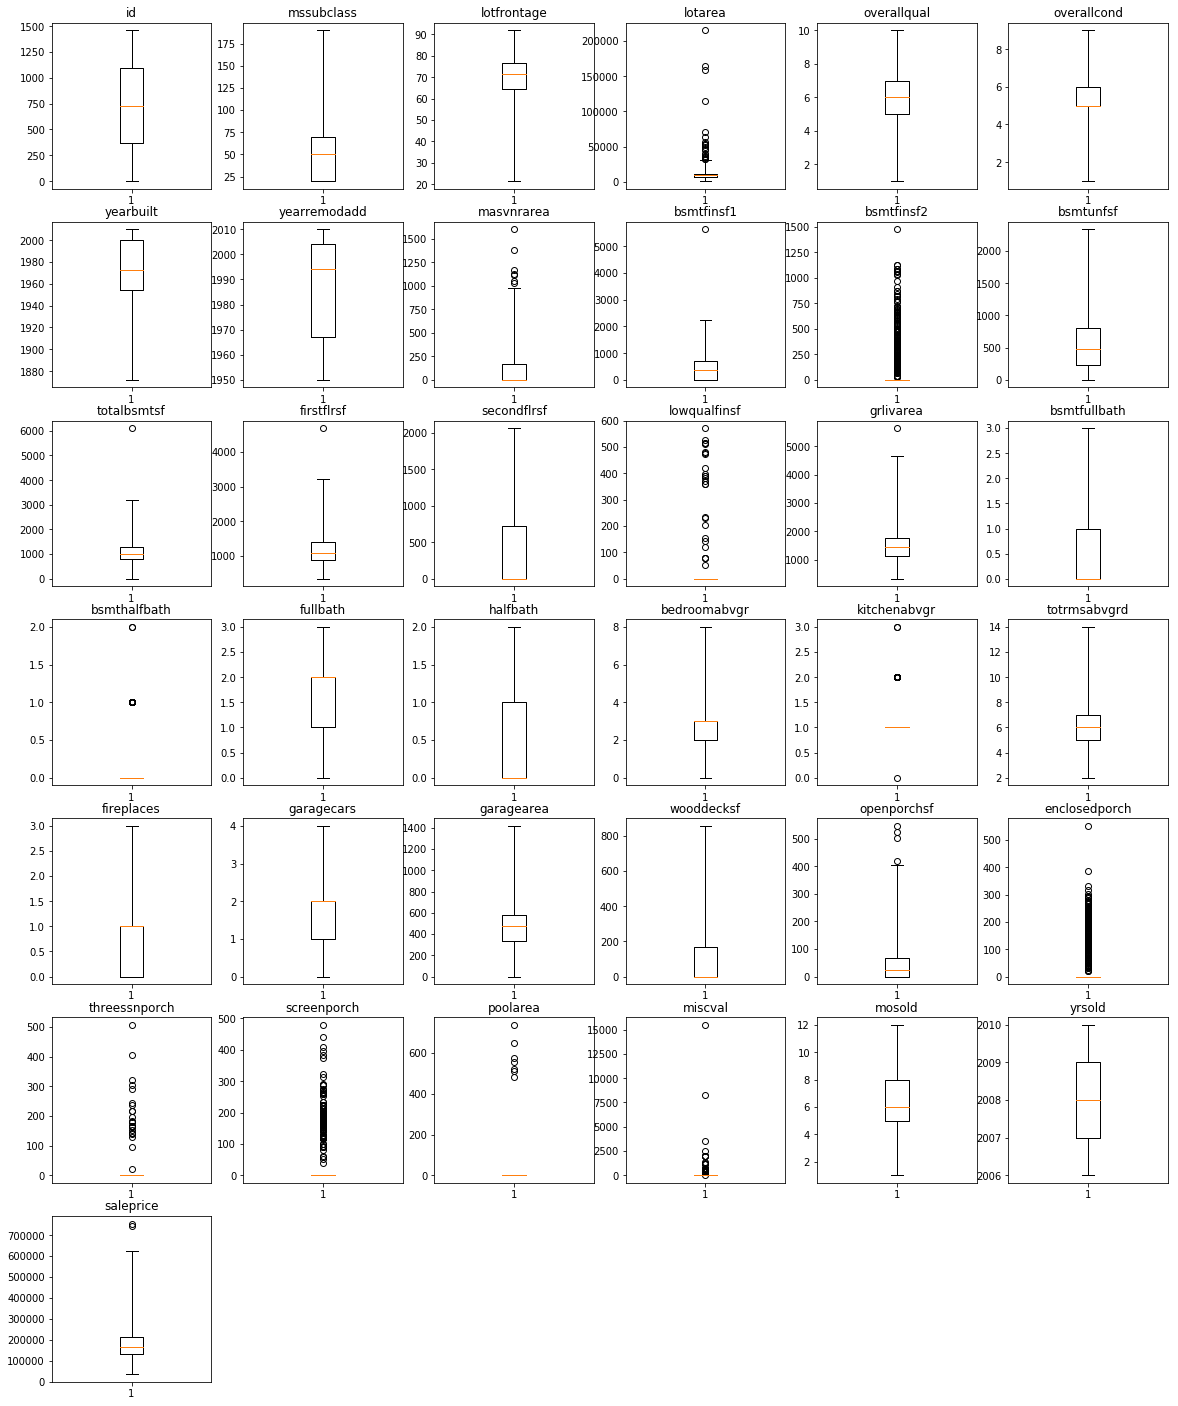

In [734]:
plt.figure(figsize = (20,25))
for i in range(0, len(numeric_columns)):
    plt.subplot(7,6,i+1)
    plt.boxplot(houses_prices[numeric_columns[i]], whis = 5)
    plt.title(numeric_columns[i])

In [827]:
outlier_features = ['lotarea', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'totalbsmtsf', 'firstflrsf', 'lowqualfinsf',
                   'grlivarea', 'bsmthalfbath', 'kitchenabvgr', 'openporchsf', 'enclosedporch', 'threessnporch', 
                    'screenporch', 'poolarea', 'miscval']
for feature in outlier_features:
    houses_prices[feature + "_win"] = winsorize(houses_prices[feature], (0.10, 0.10))

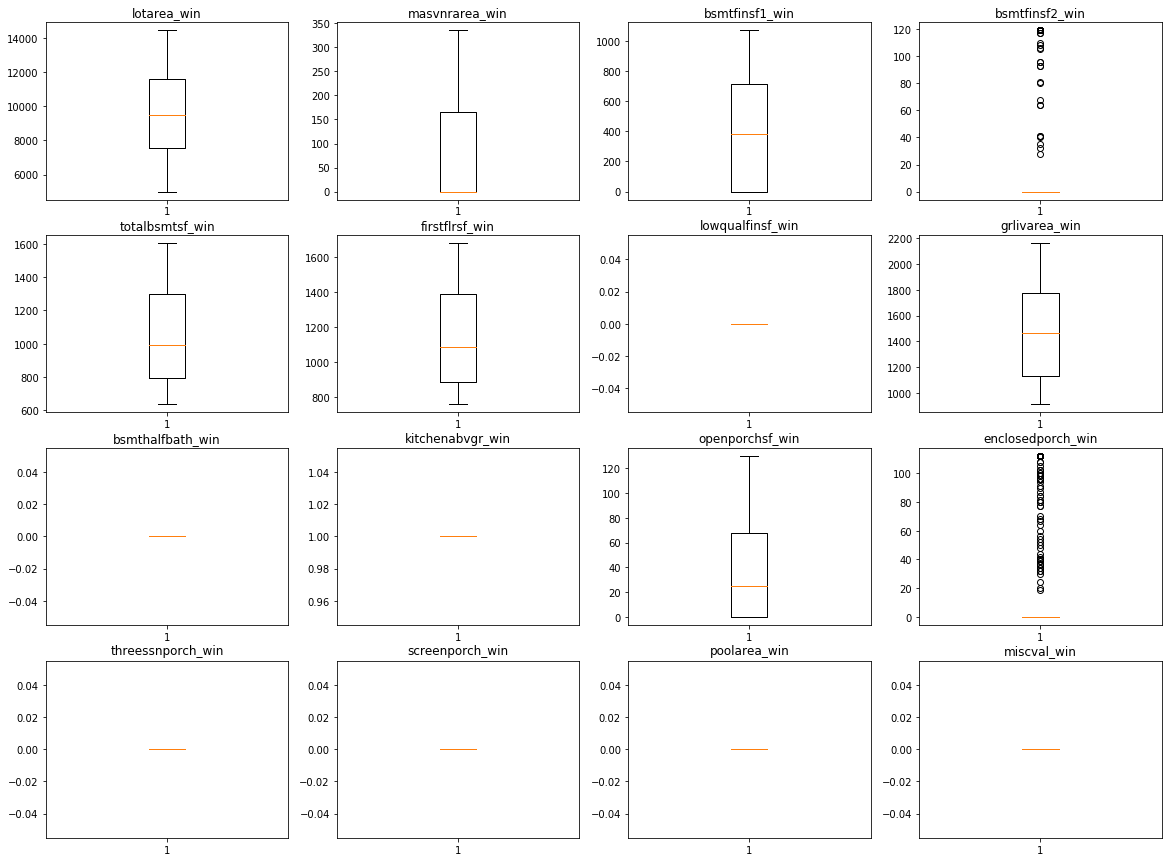

In [736]:
winsorized_features = ['lotarea_win', 'masvnrarea_win', 'bsmtfinsf1_win', 'bsmtfinsf2_win', 'totalbsmtsf_win', 
                       'firstflrsf_win', 'lowqualfinsf_win', 'grlivarea_win', 'bsmthalfbath_win', 'kitchenabvgr_win', 
                       'openporchsf_win', 'enclosedporch_win', 'threessnporch_win', 'screenporch_win', 'poolarea_win', 
                       'miscval_win']

plt.figure(figsize = (20,15))
for i in range(0, len(winsorized_features)):
    plt.subplot(4,4,i+1)
    plt.boxplot(houses_prices[winsorized_features[i]], whis = 5)
    plt.title(winsorized_features[i])

In [828]:
outlier_features_updated = ['bsmtfinsf2', 'lowqualfinsf', 'bsmthalfbath', 'kitchenabvgr', 'enclosedporch', 'threessnporch', 
                    'screenporch', 'poolarea', 'miscval']
for feature in outlier_features_updated:
    houses_prices[feature + "_norm"] = normalize(np.array(houses_prices[feature]).reshape(1,-1)).reshape(-1,1)

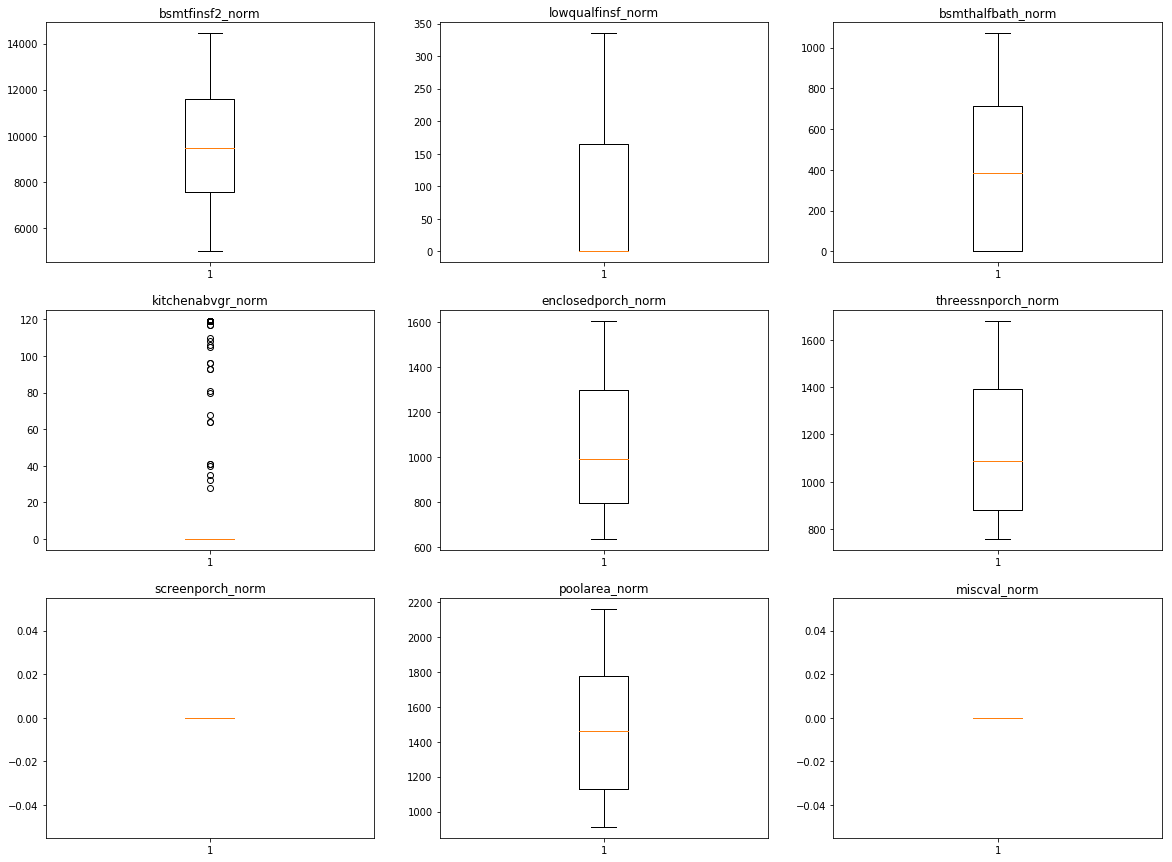

In [738]:
normalized_features = ['bsmtfinsf2_norm','lowqualfinsf_norm', 'bsmthalfbath_norm', 'kitchenabvgr_norm', 
                       'enclosedporch_norm', 'threessnporch_norm', 'screenporch_norm', 'poolarea_norm', 
                       'miscval_norm']

plt.figure(figsize = (20,15))
for i in range(0, len(normalized_features)):
    plt.subplot(3,3,i+1)
    plt.boxplot(houses_prices[winsorized_features[i]], whis = 5)
    plt.title(normalized_features[i])

In [739]:
houses_prices[["kitchenabvgr","screenporch", "miscval"]].describe()

,kitchenabvgr,screenporch,miscval
count,1459.000000,1459.000000,1459.000000
mean,1.046607,15.071282,43.518849
std,0.220410,55.775138,496.291826
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,3.000000,480.000000,15500.000000


In [740]:
len(houses_prices.loc[(houses_prices['screenporch'] != 0)]) / len(houses_prices.loc[(houses_prices['screenporch'] == 0)])

0.08637379002233805

In [741]:
len(houses_prices.loc[(houses_prices['miscval'] != 0)]) / len(houses_prices.loc[(houses_prices['miscval'] == 0)])

0.03695806680881308

In [742]:
len(houses_prices.loc[(houses_prices['kitchenabvgr'] != 1)]) / len(houses_prices.loc[(houses_prices['kitchenabvgr'] == 1)])

0.04888569374550683

In [831]:
houses_prices = houses_prices.drop(["id", 'lotarea', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'totalbsmtsf', 'firstflrsf',\
                                    'lowqualfinsf','grlivarea', 'bsmthalfbath', 'openporchsf','enclosedporch', \
                                    'threessnporch', 'screenporch', 'poolarea', 'miscval', 'bsmtfinsf1_win', \
                                    'lowqualfinsf_win', 'bsmthalfbath_win', 'kitchenabvgr_win', 'enclosedporch_win', \
                                    'threessnporch_win', 'screenporch_win', 'poolarea_win', 'miscval_win', \
                                    'kitchenabvgr_norm', 'screenporch_norm', 'miscval_norm'], axis=1)

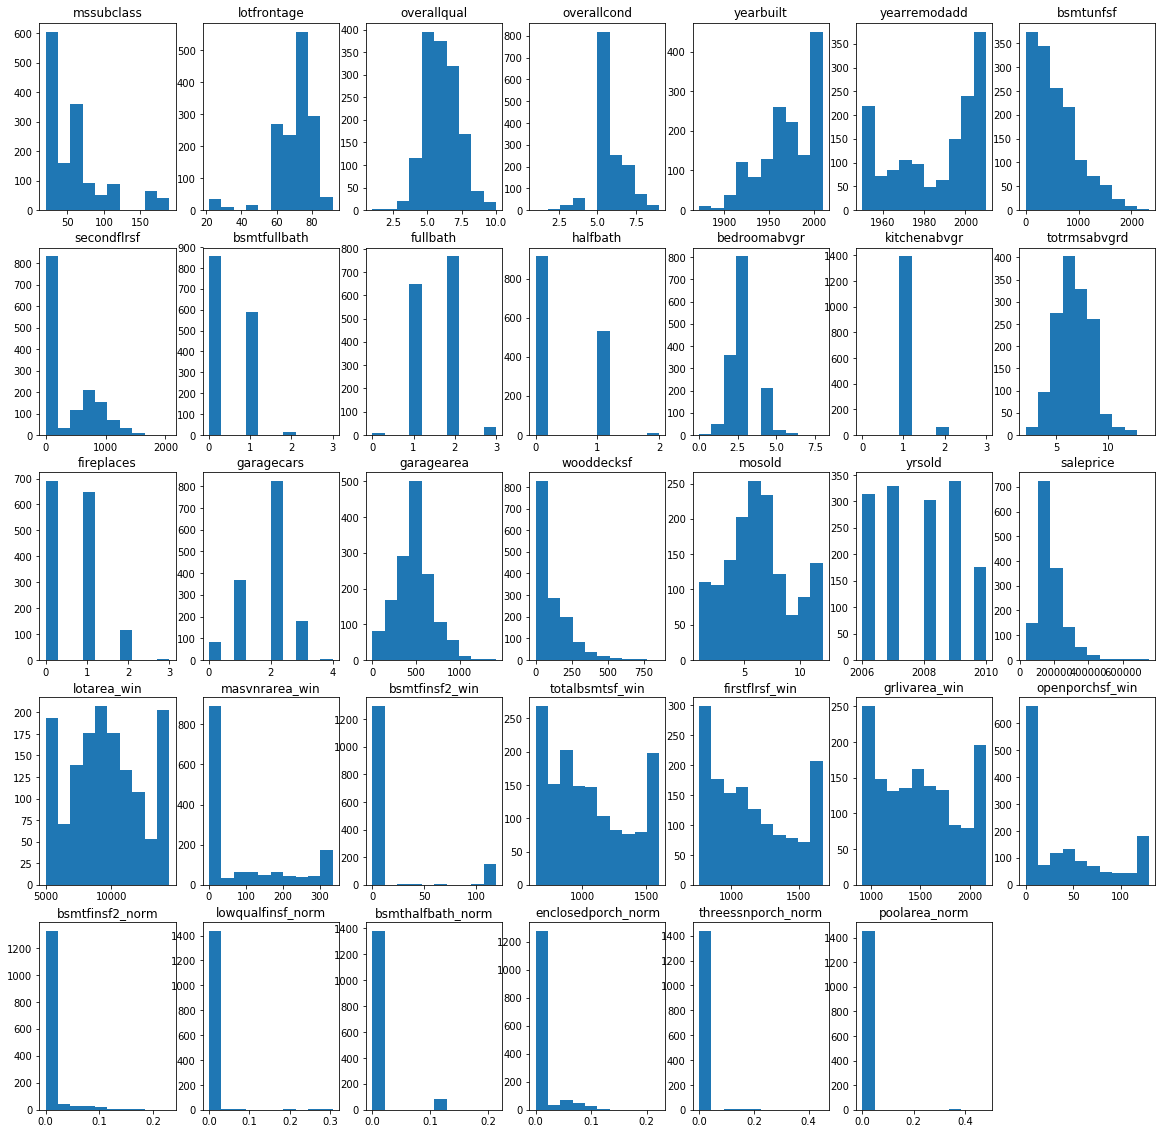

In [832]:
numeric_columns_updated = houses_prices.select_dtypes(['int64', 'float64']).columns

plt.figure(figsize = (20,20))
for index, column in enumerate(numeric_columns_updated):
    plt.subplot(5,7,index+1)
    plt.hist(houses_prices[numeric_columns_updated[index]])
    plt.title(numeric_columns_updated[index])
plt.show()

(array([157., 145., 122., 177.,  83., 209.,  75., 232.,  94., 165.]),
 array([732312. , 732476.2, 732640.4, 732804.6, 732968.8, 733133. ,
        733297.2, 733461.4, 733625.6, 733789.8, 733954. ]),
 <a list of 10 Patch objects>)

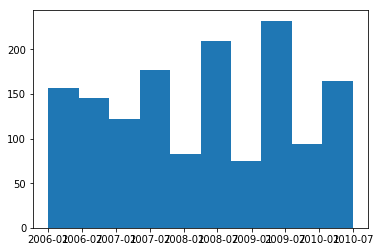

In [815]:
plt.hist(houses_prices['yr_mo_sold'])

In [833]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

for i in range(0, len(numeric_columns_updated)):
    jb_stats = jarque_bera(np.sqrt(houses_prices[numeric_columns_updated[i]]))
    norm_stats = normaltest(np.sqrt(houses_prices[numeric_columns_updated[i]]))
    print (numeric_columns_updated[i] + ":")
    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
    print("----------------------------------------------------------------------------------------")

mssubclass:
Jarque-Bera test statistics is 142.67264635001396 and p value is 0.0
Normality test statistics is 115.37661197699269 and p value is 8.836637485532076e-26
----------------------------------------------------------------------------------------
lotfrontage:
Jarque-Bera test statistics is 6487.014485167787 and p value is 0.0
Normality test statistics is 803.7639638981744 and p value is 2.916573081578778e-175
----------------------------------------------------------------------------------------
overallqual:
Jarque-Bera test statistics is 47.166043383853214 and p value is 5.728273411165219e-11
Normality test statistics is 31.9315207215224 and p value is 1.164550633391743e-07
----------------------------------------------------------------------------------------
overallcond:
Jarque-Bera test statistics is 218.5119974561949 and p value is 0.0
Normality test statistics is 73.57097161525053 and p value is 1.0574662116605897e-16
----------------------------------------------------

In [834]:
features = ['lotfrontage', 'overallqual', 'overallcond', 'yearbuilt','yearremodadd', 'bsmtunfsf', 
                      'secondflrsf', 'bsmtfullbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'totrmsabvgrd','fireplaces', 
                      'garagecars', 'garagearea', 'wooddecksf', 'saleprice', 'lotarea_win', 
                      'masvnrarea_win', 'bsmtfinsf2_win', 'totalbsmtsf_win', 'firstflrsf_win', 'grlivarea_win',
                      'openporchsf_win', 'bsmtfinsf2_norm', 'lowqualfinsf_norm', 'bsmthalfbath_norm', 'enclosedporch_norm', 
                      'threessnporch_norm', 'poolarea_norm']

for feature in features:
    houses_prices = houses_prices.replace({feature : {0: 0.000000001}})

In [835]:
for feature in features:
    houses_prices[feature + "_boxcox"],_ = boxcox(houses_prices[feature])    

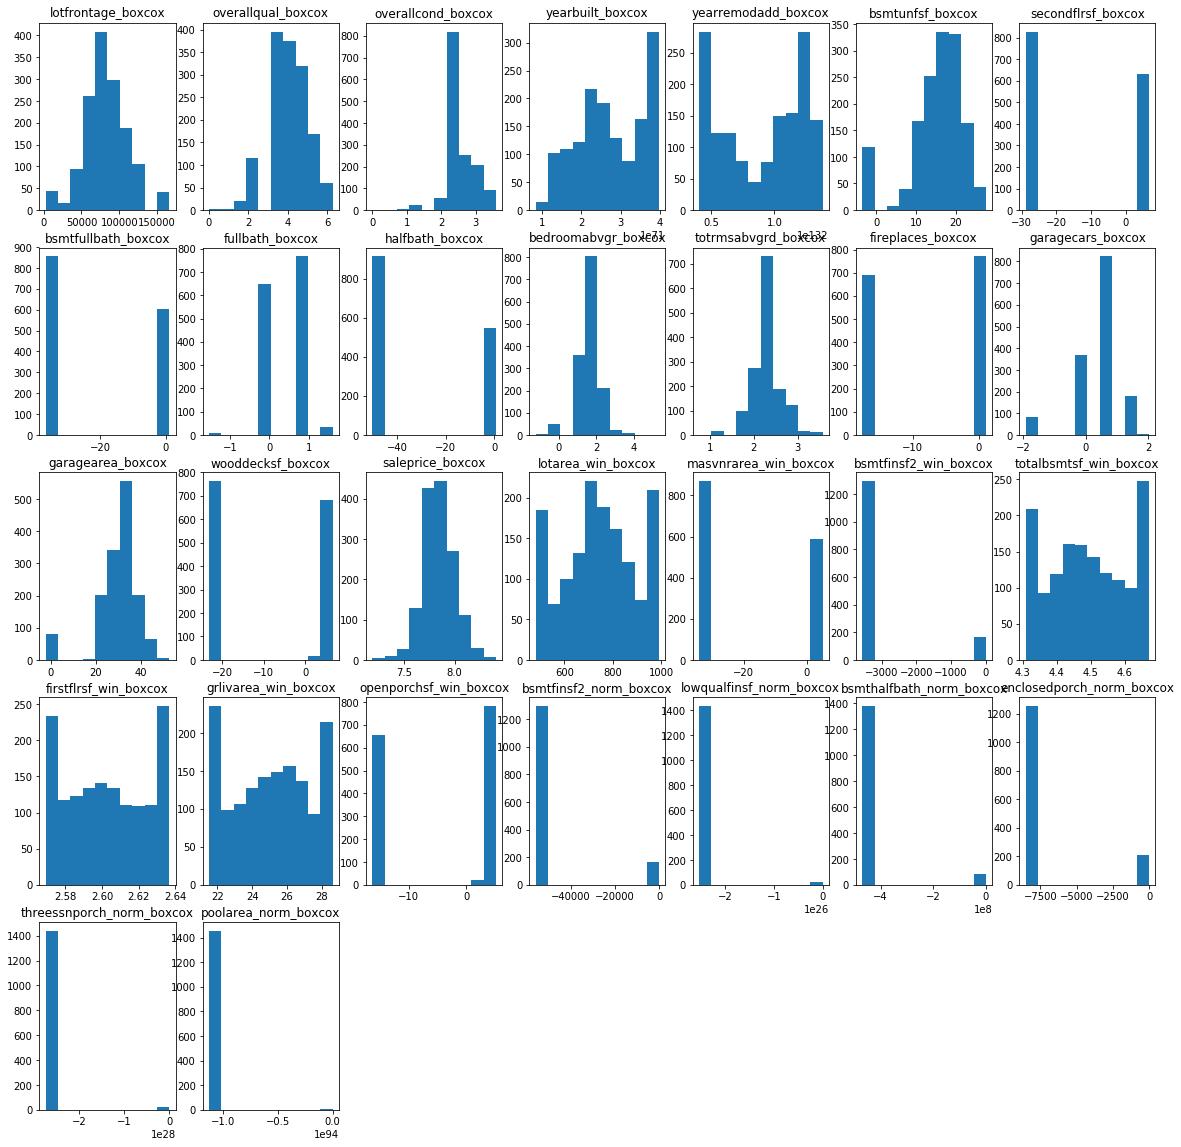

In [837]:
boxcox_features = ['lotfrontage_boxcox', 'overallqual_boxcox', 'overallcond_boxcox', 'yearbuilt_boxcox',
                   'yearremodadd_boxcox', 'bsmtunfsf_boxcox', 'secondflrsf_boxcox', 'bsmtfullbath_boxcox', 
                   'fullbath_boxcox', 'halfbath_boxcox', 'bedroomabvgr_boxcox', 'totrmsabvgrd_boxcox','fireplaces_boxcox', 
                   'garagecars_boxcox', 'garagearea_boxcox', 'wooddecksf_boxcox', 'saleprice_boxcox', 'lotarea_win_boxcox', 
                   'masvnrarea_win_boxcox', 'bsmtfinsf2_win_boxcox', 'totalbsmtsf_win_boxcox', 'firstflrsf_win_boxcox', 
                   'grlivarea_win_boxcox', 'openporchsf_win_boxcox', 'bsmtfinsf2_norm_boxcox', 'lowqualfinsf_norm_boxcox', 
                   'bsmthalfbath_norm_boxcox', 'enclosedporch_norm_boxcox', 'threessnporch_norm_boxcox',
                   'poolarea_norm_boxcox']

plt.figure(figsize = (20,20))
for index, column in enumerate(boxcox_features):
    plt.subplot(5,7,index+1)
    plt.hist(houses_prices[boxcox_features[index]])
    plt.title(boxcox_features[index])
plt.show()

In [838]:
for i in range(0, len(boxcox_features)):
    jb_stats = jarque_bera(np.sqrt(houses_prices[boxcox_features[i]]))
    norm_stats = normaltest(np.sqrt(houses_prices[boxcox_features[i]]))
    print (boxcox_features[i] + ":")
    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
    print("----------------------------------------------------------------------------------------")

lotfrontage_boxcox:
Jarque-Bera test statistics is 997.373960664036 and p value is 0.0
Normality test statistics is 346.67025536395766 and p value is 5.2663598090799463e-76
----------------------------------------------------------------------------------------
overallqual_boxcox:
Jarque-Bera test statistics is 2128.890199164679 and p value is 0.0
Normality test statistics is 338.2783779921109 and p value is 3.497707960349989e-74
----------------------------------------------------------------------------------------
overallcond_boxcox:
Jarque-Bera test statistics is 13562.915869722628 and p value is 0.0
Normality test statistics is 592.3080027648382 and p value is 2.4096357953301648e-129
----------------------------------------------------------------------------------------
yearbuilt_boxcox:
Jarque-Bera test statistics is 81.77451450785054 and p value is 0.0
Normality test statistics is 230.27472485427916 and p value is 9.919250019410648e-51
------------------------------------------

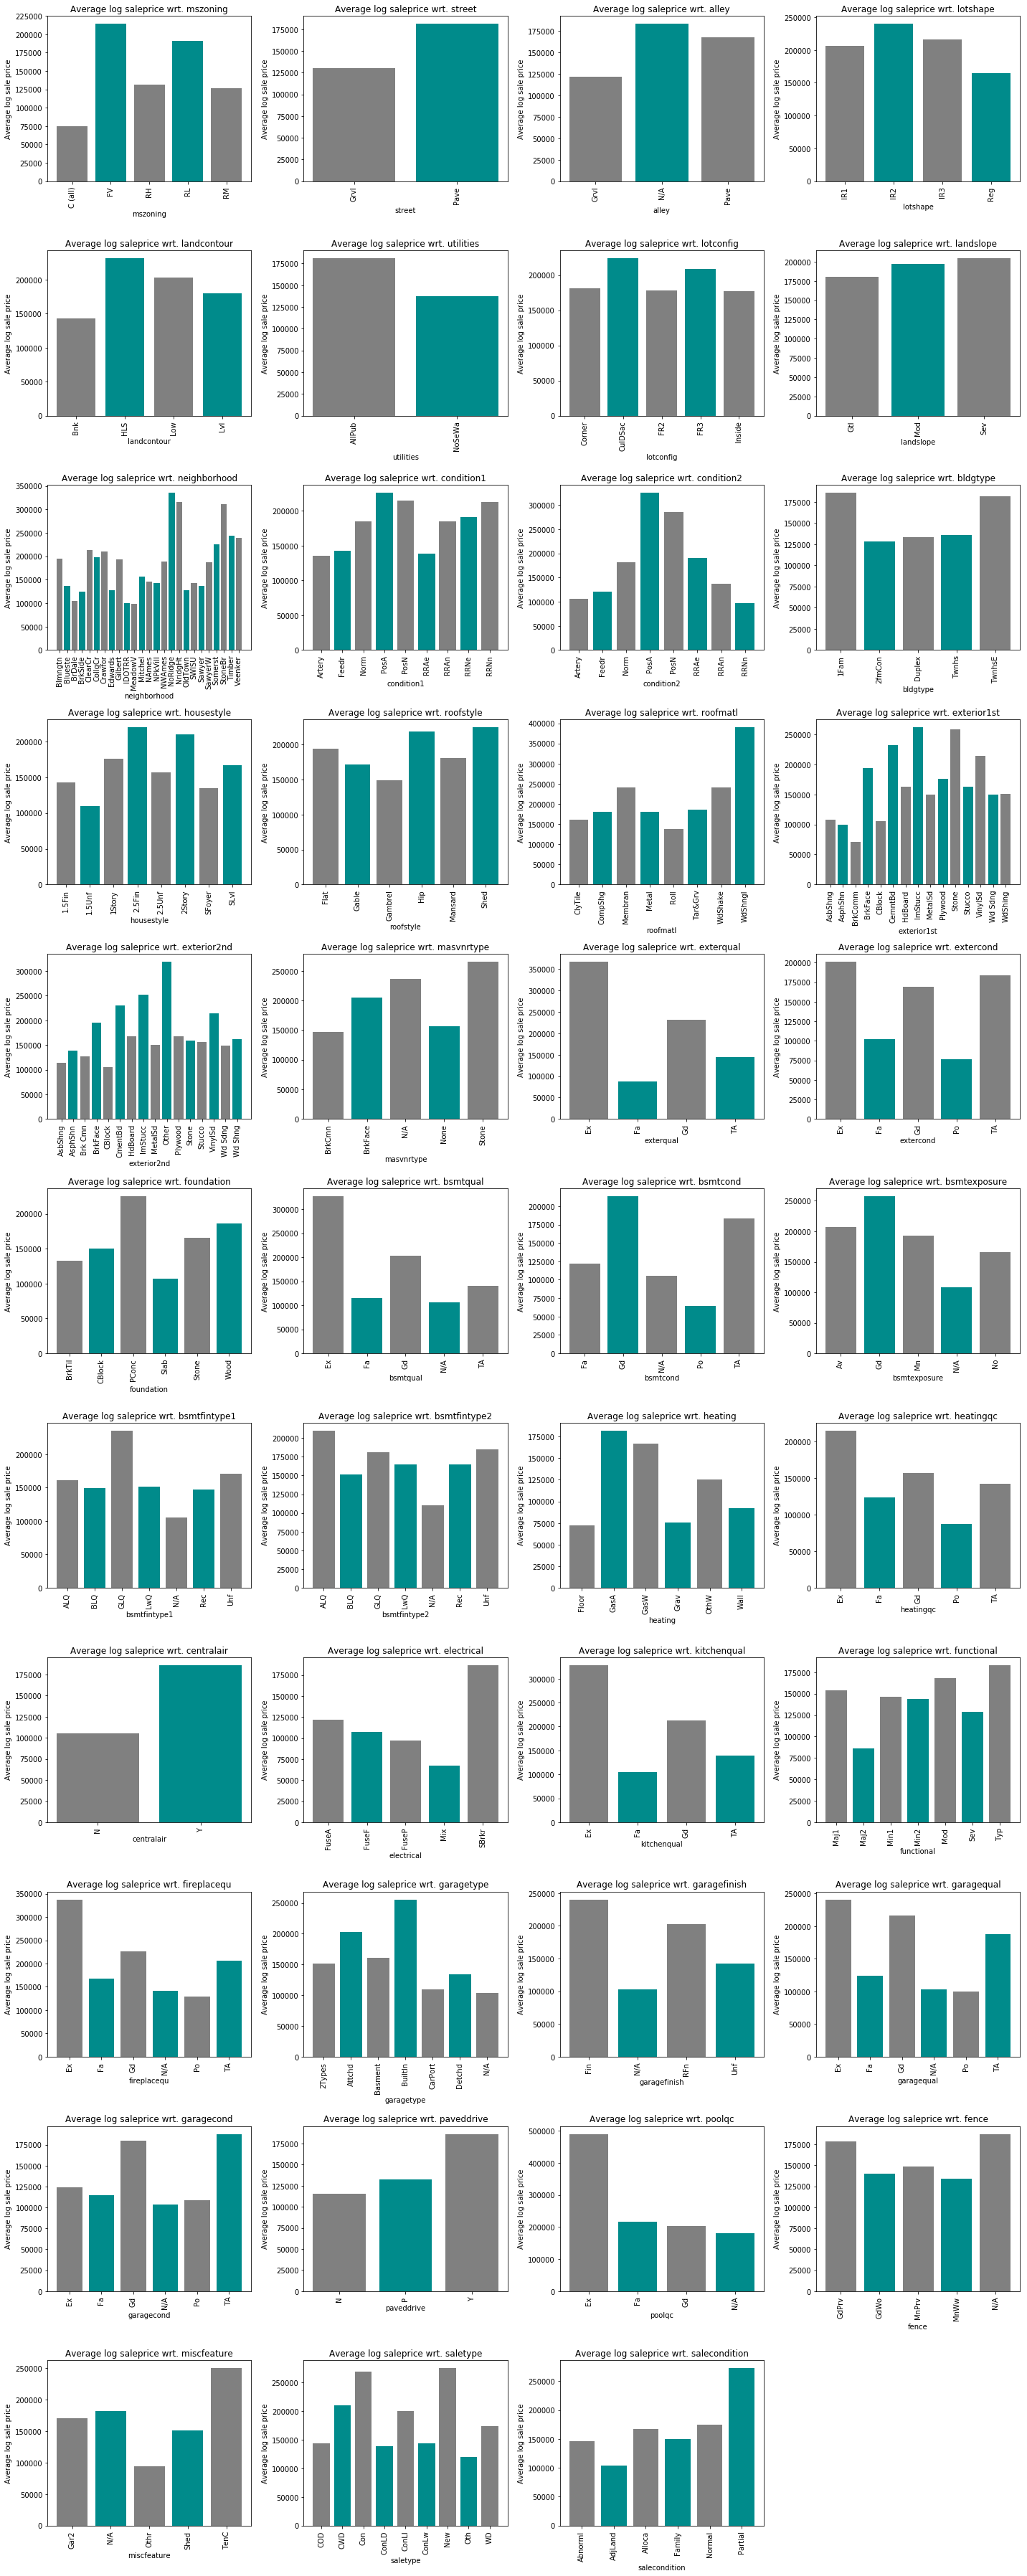

In [521]:
plt.figure(figsize=(20,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(houses_prices.groupby(column)["saleprice"].mean().index, houses_prices.groupby(column)["saleprice"].mean(),
           color=("grey","darkcyan"))
    plt.title("Average log saleprice wrt. {}".format(column))
    plt.ylabel("Average log sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [848]:
np.abs(houses_prices[numeric_columns_updated].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice             1.000000
overallqual           0.791069
grlivarea_win         0.678605
garagecars            0.640473
garagearea            0.623423
totalbsmtsf_win       0.608246
firstflrsf_win        0.583141
fullbath              0.560881
totrmsabvgrd          0.533779
yearbuilt             0.523273
yearremodadd          0.507430
fireplaces            0.466968
lotarea_win           0.451401
masvnrarea_win        0.438046
openporchsf_win       0.389730
lotfrontage           0.352445
wooddecksf            0.324422
secondflrsf           0.319464
halfbath              0.284400
bsmtfullbath          0.227082
bsmtunfsf             0.214446
bedroomabvgr          0.168235
kitchenabvgr          0.135935
enclosedporch_norm    0.128627
poolarea_norm         0.092397
overallcond           0.077924
bsmtfinsf2_win        0.053100
mosold                0.046380
threessnporch_norm    0.044571
yrsold                0.028907
lowqualfinsf_norm     0.025620
bsmthalfbath_norm     0.016873
bsmtfins

In [849]:
np.abs(houses_prices[boxcox_features].iloc[:,1:].corr().loc[:,"saleprice_boxcox"]).sort_values(ascending=False)

saleprice_boxcox             1.000000
overallqual_boxcox           0.814014
grlivarea_win_boxcox         0.709280
garagecars_boxcox            0.623041
yearbuilt_boxcox             0.619924
totalbsmtsf_win_boxcox       0.612817
garagearea_boxcox            0.592862
fullbath_boxcox              0.581005
firstflrsf_win_boxcox        0.579379
yearremodadd_boxcox          0.562133
totrmsabvgrd_boxcox          0.538842
fireplaces_boxcox            0.511482
openporchsf_win_boxcox       0.454289
lotarea_win_boxcox           0.454022
masvnrarea_win_boxcox        0.384811
halfbath_boxcox              0.328588
wooddecksf_boxcox            0.324987
bsmtfullbath_boxcox          0.238760
enclosedporch_norm_boxcox    0.217997
bsmtunfsf_boxcox             0.216202
bedroomabvgr_boxcox          0.209527
secondflrsf_boxcox           0.155518
poolarea_norm_boxcox         0.068393
threessnporch_norm_boxcox    0.058400
lowqualfinsf_norm_boxcox     0.057151
bsmtfinsf2_win_boxcox        0.032709
bsmtfinsf2_n

In [569]:
corrmat_houses = houses_prices[['overallqual', 'grlivarea_win','garagecars', 'garagearea', 'totalbsmtsf_win', 'fullbath', 
                                'firstflrsf_win', 'yearbuilt', 'yearremodadd', 'totrmsabvgrd']].corr()

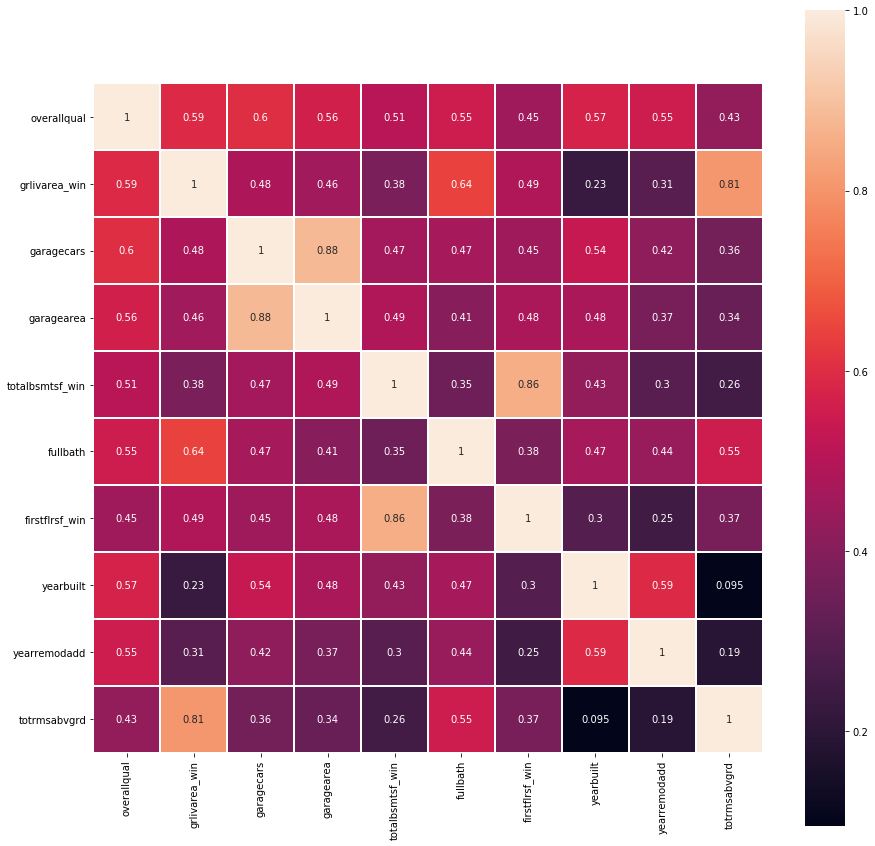

In [524]:
plt.figure(figsize = (15,15))
sns.heatmap(corrmat_houses, square = True, annot = True, linewidths = 0.5)

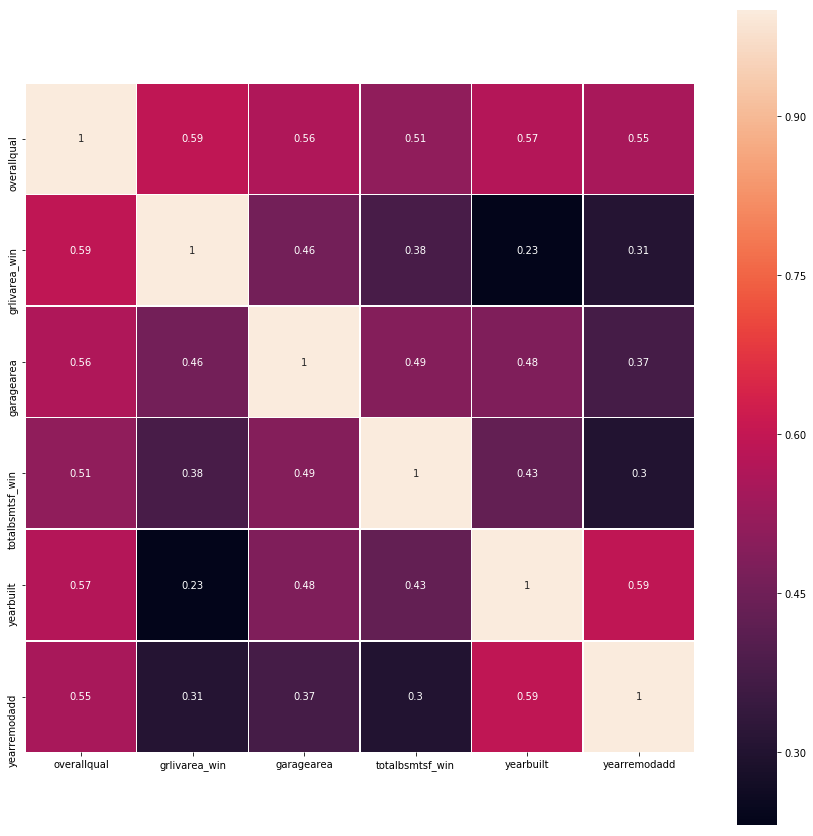

In [570]:
selected_features = ['overallqual', 'grlivarea_win','garagearea', 'totalbsmtsf_win', 'yearbuilt', 'yearremodadd']

corrmat_selected = houses_prices[selected_features].corr()

plt.figure(figsize = (15,15))
sns.heatmap(corrmat_selected, square = True, annot = True, linewidths = 0.5)

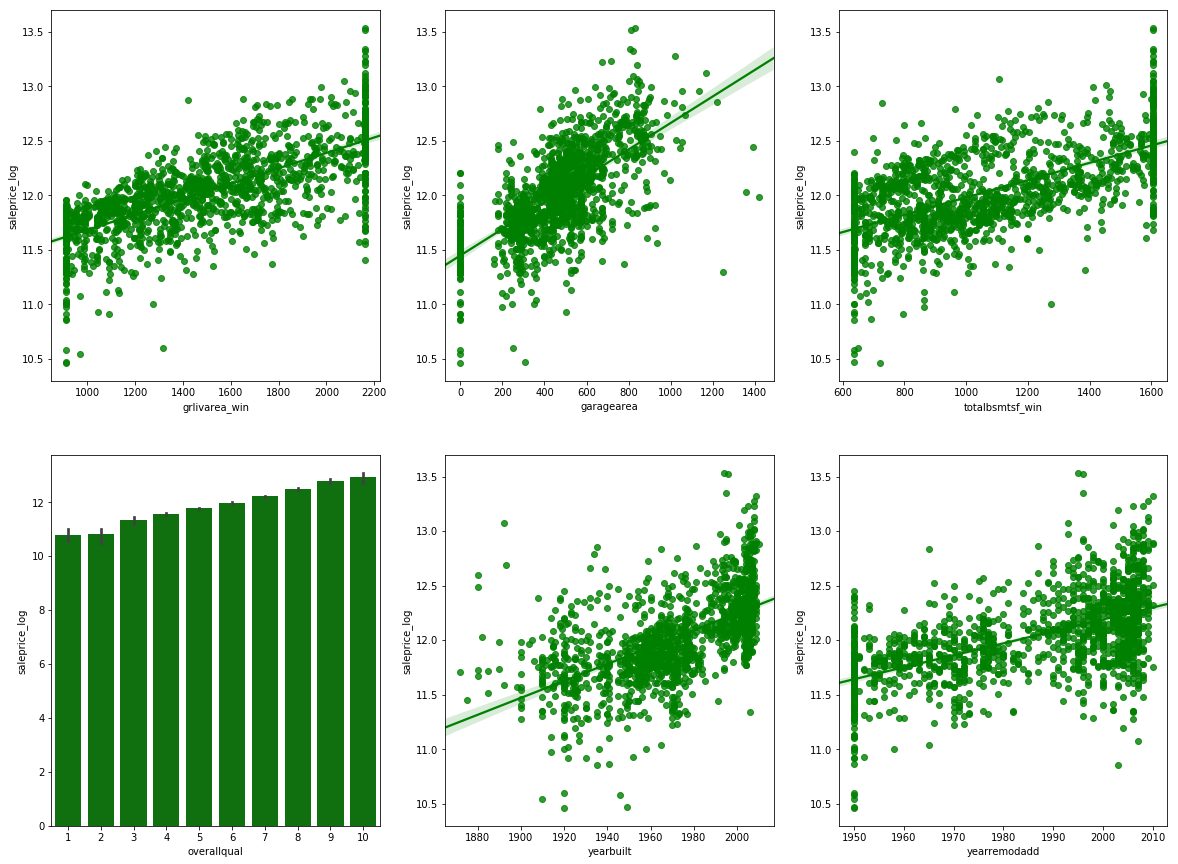

In [525]:
plt.figure(figsize=(20,15))

plt.subplot(2,3,1)
sns.regplot(houses_prices['grlivarea_win'], houses_prices['saleprice_log'], color = 'green')

plt.subplot(2,3,2)
sns.regplot(houses_prices['garagearea'], houses_prices['saleprice_log'], color = 'green')

plt.subplot(2,3,3)
sns.regplot(houses_prices['totalbsmtsf_win'], houses_prices['saleprice_log'], color = 'green')

plt.subplot(2,3,4)
sns.barplot(houses_prices['overallqual'], houses_prices['saleprice_log'], color = 'green')

plt.subplot(2,3,5)
sns.regplot(houses_prices['yearbuilt'], houses_prices['saleprice_log'], color = 'green')

plt.subplot(2,3,6)
sns.regplot(houses_prices['yearremodadd'], houses_prices['saleprice_log'], color = 'green')

In [526]:
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.street, prefix="street", drop_first=True)], axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.utilities, prefix="utilities", drop_first=True)], 
                          axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.exterqual, prefix="exterqual", drop_first=True)], 
                          axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.bsmtqual, prefix="bsmtqual", drop_first=True)], 
                          axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.heatingqc, prefix="heatingqc", drop_first=True)], 
                          axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.centralair, prefix="centralair", drop_first=True)], 
                          axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.electrical, prefix="electrical", drop_first=True)], 
                          axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.kitchenqual, prefix="kitchenqual", drop_first=True)], 
                          axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.fireplacequ, prefix="fireplacequ", drop_first=True)], 
                          axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.garagefinish, prefix="garagefinish", drop_first=True)]
                          , axis=1)
houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices.paveddrive, prefix="paveddrive", drop_first=True)], 
                          axis=1)
dummy_column_names = list(pd.get_dummies(houses_prices.street, prefix="street", drop_first=True).columns)
dummy_column_names = dummy_column_names \
                    + list(pd.get_dummies(houses_prices.utilities, prefix="utilities", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.exterqual, prefix="exterqual", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.bsmtqual, prefix="bsmtqual", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.heatingqc, prefix="heatingqc", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.centralair, prefix="centralair", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.electrical, prefix="electrical", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.kitchenqual, prefix="kitchenqual", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.fireplacequ, prefix="fireplacequ", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.garagefinish, prefix="garagefinish", drop_first=True).columns) \
                    + list(pd.get_dummies(houses_prices.paveddrive, prefix="paveddrive", drop_first=True).columns)

In [529]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1167
The number of observations in test set is 292


In [572]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_log   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     194.0
Date:                Tue, 27 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:58:25   Log-Likelihood:                 572.50
No. Observations:                1167   AIC:                            -1071.
Df Residuals:                    1130   BIC:                            -883.7
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.7603      0.803      8.414      0.000       5.184       8.337
overallqual          0.0782      0.006     12.703      0.000       0.066       0.090
grlivarea_win        0.0003   1.56e-05     19.582      0.000       0.000       0.000
garagearea           0.0002   3.24e-05      5.901      0.000       0.000       0.000
totalbsmtsf_win      0.0002   1.83e-05     11.300      0.000       0.000       0.000
yearbuilt            0.0005      0.000      1.562      0.119      -0.000       0.001
yearremodadd         0.0016      0.000      4.919      0.000       0.001       0.002
street_Pave         -0.0424      0.072     -0.591      0.555      -0.183       0.098
utilities_NoSeWa    -0.0861      0.153     -0.561      0.575      -0.387       0.215
exterqual_Fa        -0.1187      0.065     -1.833      0.067      -0.246       0.008
exterqual_Gd        -0.0452      0.032     -1.431      0.153      -0.107       0.017
exterqual_TA        -0.0291      0.035     -0.830      0.407      -0.098       0.040
bsmtqual_Fa         -0.0634      0.041     -1.560      0.119      -0.143       0.016
bsmtqual_Gd         -0.0318      0.022     -1.460      0.145      -0.075       0.011
bsmtqual_N/A        -0.0838      0.039     -2.172      0.030      -0.160      -0.008
bsmtqual_TA         -0.0459      0.026     -1.773      0.076      -0.097       0.005
heatingqc_Fa        -0.0264      0.028     -0.959      0.338      -0.080       0.028
heatingqc_Gd        -0.0152      0.014     -1.074      0.283      -0.043       0.013
heatingqc_Po       5.93e-13   2.11e-13      2.807      0.005    1.79e-13    1.01e-12
heatingqc_TA        -0.0300      0.013     -2.341      0.019      -0.055      -0.005
centralair_Y         0.1469      0.023      6.431      0.000       0.102       0.192
electrical_FuseF     0.0603      0.040      1.504      0.133      -0.018       0.139
electrical_FuseP    -0.0175      0.095     -0.185      0.854      -0.203       0.169
electrical_Mix      -0.4311      0.156     -2.771      0.006      -0.736      -0.126
electrical_SBrkr     0.0231      0.020      1.161      0.246      -0.016       0.062
kitchenqual_Fa      -0.0725      0.041     -1.765      0.078      -0.153       0.008
kitchenqual_Gd      -0.0520      0.024     -2.194      0.028      -0.098      -0.005
kitchenqual_TA      -0.0773      0.027     -2.917      0.004      -0.129      -0.025
fireplacequ_Fa      -0.0635      0.049     -1.290      0.197      -0.160       0.033
fireplacequ_Gd      -0.0610      0.039     -1.574      0.116      -0.137       0.015
fireplacequ_N/A     -0.1171      0.040     -2.909      0.004      -0.196      -0.038
fireplacequ_Po      -0.1107      0.055     -2.030      0.043      -0.218      -0.004
fireplacequ_TA      -0.0644      0.040     -1.597      0.111      -0.144       0.015
garagefinish_N/A    -0.

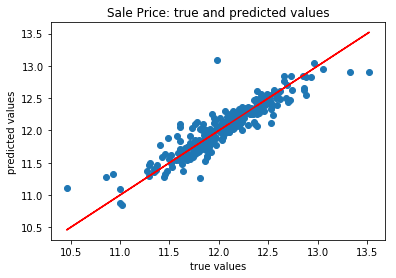

Mean absolute error of the prediction is: 0.1125402171865716
Mean squared error of the prediction is: 0.027170706542649976
Root mean squared error of the prediction is: 0.16483539226346378
Mean absolute percentage error of the prediction is: 0.9396922793657175


In [532]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Sale Price: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


In [538]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))

R-squared of the model in training set is: 0.8607334548326191
R-squared of the model in test set is: 0.8375396910895545


In [536]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [541]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.8586353656054623
-----Test set statistics-----
R-squared of the model in test set is: 0.8362685867384663
Mean absolute error of the prediction is: 0.11268392425237388
Mean squared error of the prediction is: 0.02738329264161847
Root mean squared error of the prediction is: 0.1654789794554537
Mean absolute percentage error of the prediction is: 0.9406394182536101


In [542]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.860406820940405
-----Test set statistics-----
R-squared of the model in test set is: 0.8382953776935818
Mean absolute error of the prediction is: 0.1120795445598668
Mean squared error of the prediction is: 0.027044321586878604
Root mean squared error of the prediction is: 0.16445157824380588
Mean absolute percentage error of the prediction is: 0.935827235972231


In [543]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.8572749756933306
-----Test set statistics-----
R-squared of the model in test set is: 0.8335356103446661
Mean absolute error of the prediction is: 0.113851943462301
Mean squared error of the prediction is: 0.027840369819927126
Root mean squared error of the prediction is: 0.16685433713250347
Mean absolute percentage error of the prediction is: 0.9502081517991524


In [887]:
unemployment=pd.read_csv('C:/Users/rabia/Desktop/Thinkful/unemployment06_10.csv', encoding='Latin-1')

In [890]:
unemployment.head()

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,2006,4.7,4.8,4.7,4.7,4.6,4.6,4.7,4.7,4.5,4.4,4.5,4.4
1,2007,4.6,4.5,4.4,4.5,4.4,4.6,4.7,4.6,4.7,4.7,4.7,5.0
2,2008,5.0,4.9,5.1,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3
3,2009,7.8,8.3,8.7,9.0,9.4,9.5,9.5,9.6,9.8,10.0,9.9,9.9
4,2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3


In [857]:
unemployment.iloc[:,1]

0    4.7
1    4.6
2    5.0
3    7.8
4    9.8
Name: Jan, dtype: float64

In [889]:
unemployment.columns = ['year',1,2,3,4,5,6,7,8,9,10,11,12]

In [873]:
unemployment.set_index('year')

,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2006,4.7,4.8,4.7,4.7,4.6,4.6,4.7,4.7,4.5,4.4,4.5,4.4
2007,4.6,4.5,4.4,4.5,4.4,4.6,4.7,4.6,4.7,4.7,4.7,5.0
2008,5.0,4.9,5.1,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3
2009,7.8,8.3,8.7,9.0,9.4,9.5,9.5,9.6,9.8,10.0,9.9,9.9
2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3


In [885]:
houses_prices['unemplopyment'] = unemployment.loc[houses_prices.yrsold, houses_prices.mosold]

KeyError: "None of [Int64Index([2008, 2007, 2008, 2006, 2008, 2009, 2007, 2009, 2008, 2008,\n            ...\n            2009, 2009, 2006, 2006, 2009, 2007, 2010, 2010, 2010, 2008],\n           dtype='int64', length=1459)] are in the [index]"

In [894]:
houses_prices_short = houses_prices[['yrsold', 'mosold']]

In [895]:
houses_prices_short.head()

,yrsold,mosold
0,2008,2
1,2007,5
2,2008,9
3,2006,2
4,2008,12


In [897]:
houses_prices_short['unemplopyment'] = unemployment.loc[houses_prices_short['yrsold'], houses_prices_short['mosold']]

KeyError: "None of [Int64Index([2008, 2007, 2008, 2006, 2008, 2009, 2007, 2009, 2008, 2008,\n            ...\n            2009, 2009, 2006, 2006, 2009, 2007, 2010, 2010, 2010, 2008],\n           dtype='int64', length=1459)] are in the [index]"